Όνομα: Βασίλειος Ραφαήλ Αβραμίδης

Αριθμός Μητρώου: ics23033

Μάθημα: Ανάλυση Δεδομένων μεγάλου Όγκου (Big Data)

Εργασία: Flight Delay Analytics με Apache Spark


In [ ]:
#Installing PySpark and JDK packages.
!pip -q install pyspark
!pip -q install matplotlib
!apt-get install openjdk-11-jdk -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libxcomposite1 libxt-dev libxtst6 libxxf86dga1
  openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  session-migration x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libxcomposite1 libxt-dev libxtst6 libxxf86dga1
  openjdk-11-jdk openjdk-11-jdk-headless openjdk-

In [ ]:
#Getting the flights_2000.csv file from GitHub.
csv_filename = "flights_2000.csv"
csv_url = f"https://raw.githubusercontent.com/billavramidis/spark-flight-delay-analysis/refs/heads/main/data/{csv_filename}"


!wget -q -O {csv_filename} {csv_url}

In [ ]:
#Importing Spark and Colab.
from pyspark.sql import SparkSession
from google.colab import files

#Libraries for rounding the average delays.
from pyspark.sql.functions import format_number, col, hour, month, date_format
from pyspark.sql.types import DoubleType

#Libraries necessary for saving the result as .csv file.
import glob
import shutil
import os

#Library for plotting the result.
from matplotlib import pyplot as plt

In [ ]:
def save_file(final_file, dataframe):
  temp_folder = "csv_folder"

  #If a previous result exists, it gets removed.
  if os.path.exists(final_file) and os.path.isfile(final_file):
      os.remove(final_file)

  #Forcing Spark to create only one partition into a temporary folder.
  dataframe.coalesce(1).write.mode("overwrite").csv(temp_folder, header=True)

  #Getting the single partition file.
  temp_file = glob.glob(f"{temp_folder}/*.csv")[0]

  #Renaming the file and moving it out of the temporary folder.
  shutil.move(temp_file, final_file)

  #Removing the temporary folder.
  shutil.rmtree(temp_folder)

  #Downloading the result.
  files.download(final_file)

In [ ]:
#Starting Spark session.
spark = SparkSession.builder.appName("Flights").getOrCreate()

In [ ]:
#Reading the file.
flights_df = spark.read.csv(csv_filename, header=True, inferSchema=True)

#Printing the Flights DataFrame schema to ensure everything loaded correctly.
flights_df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DEST_AIRPORT: string (nullable = true)
 |-- SCHED_DEP: timestamp (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- SCHED_ARR: timestamp (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- DIST_KM: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)



In [ ]:
delayed_flights = (
    flights_df
    .na.drop(subset=["DEP_DELAY", "ARR_DELAY"]) #Filtering out NULL or empty values from the ‘DEP_DELAY’ column.
    .filter((col("DEP_DELAY") > 0) & (col("CANCELLED") == 0)) #Filtering out flights that were cancelled ‘CANCELLED = 1’ and the flights that were on schedule or earlier ‘DEP_DELAY < 0’.
)

In [ ]:
delays_by_hour = (
    delayed_flights
    .withColumn("HOUR", hour(col("SCHED_DEP")))
    .groupBy("HOUR")
    .avg("DEP_DELAY")
    .withColumnRenamed("avg(DEP_DELAY)", "AVG_DEP_DELAY")
    .orderBy("AVG_DEP_DELAY", ascending = False)
    .withColumn("AVG_DEP_DELAY", format_number(col("AVG_DEP_DELAY").cast(DoubleType()), 2))
)

In [ ]:
airline_delays = (
    delayed_flights
      .groupBy("AIRLINE")
      .count()
      .withColumnRenamed("count", "DELAYS")
      .orderBy("DELAYS", ascending = False)
)

In [ ]:
month_delays = (
    delayed_flights
      .withColumn("YEAR_MONTH", date_format(col("SCHED_DEP"), "yyyy-MM"))
      .groupBy("YEAR_MONTH")
      .count()
      .withColumnRenamed("count", "DELAYS")
      .orderBy("DELAYS", ascending=False)
)

In [ ]:
#Saving Average Departure Delay by Hour.
save_file("average_hour_delay.csv", delays_by_hour)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Saving Departure Delays Per Airline.
save_file("airline_delays.csv", airline_delays)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Saving Departure Delays Per Month.
save_file("month_delays.csv", month_delays)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def plot_bar(dataframe, labels, color, width, filename):
    pdf = dataframe.toPandas()


    col_x = pdf.columns[0]
    col_y = pdf.columns[1]

    x_values = pdf[col_x].astype(str)

    y_values = pdf[col_y].astype(float)

    xlabel, ylabel, title = labels

    plt.figure(figsize=(12, 6))
    bars = plt.bar(x_values, y_values, color=color, width=width)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.bar_label(bars, fmt='%.2f', padding=3)

    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0)
    plt.tight_layout()

    plt.savefig(filename)
    plt.show()
    plt.close()

    files.download(filename)


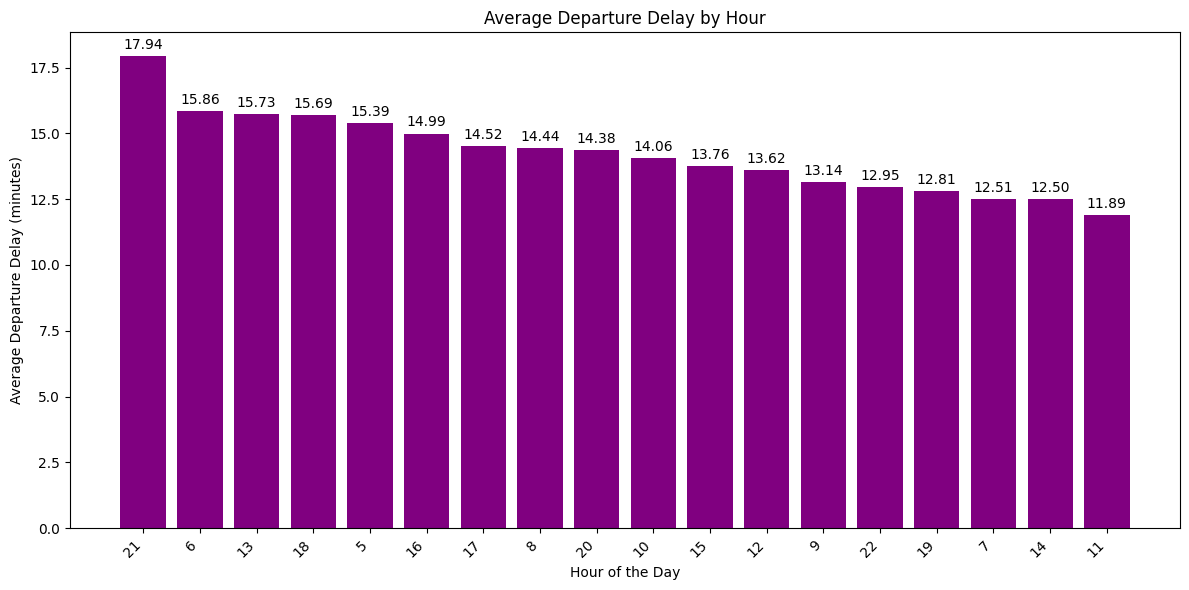

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Plotting Average Departure Delay by Hour.
labels = ["Hour of the Day", "Average Departure Delay (minutes)", "Average Departure Delay by Hour"]
plot_bar(delays_by_hour, labels, "purple", 0.8, "average_hour_delay.png")

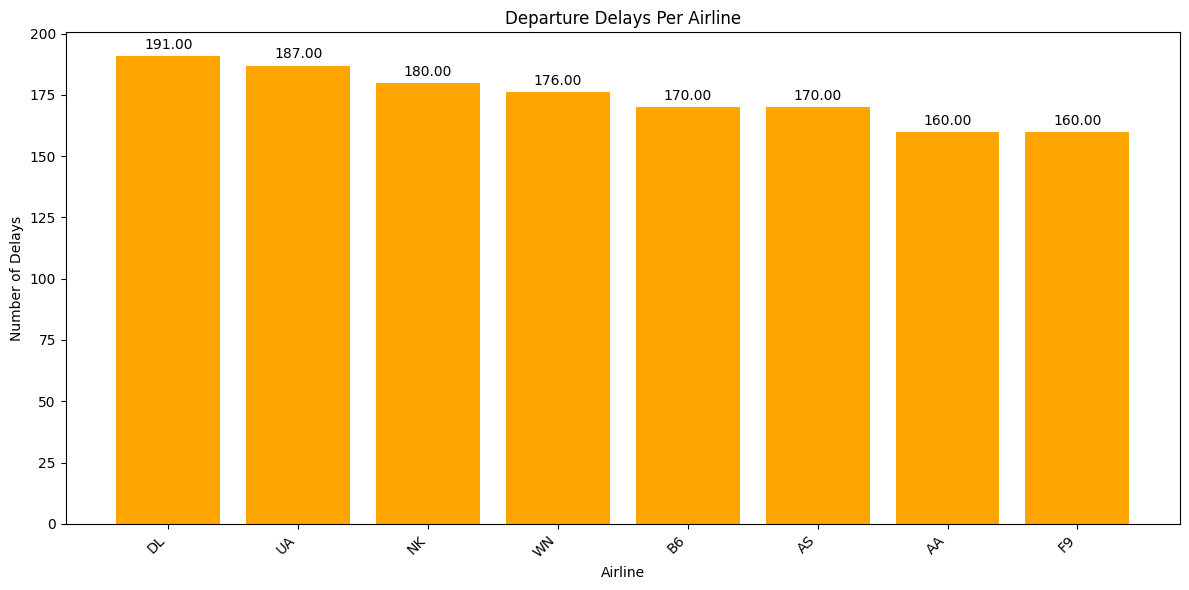

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Plotting Departure Delays Per Airline.
labels = ["Airline", "Number of Delays", "Departure Delays Per Airline"]
plot_bar(airline_delays, labels, "orange", 0.8, "airline_delays.png")

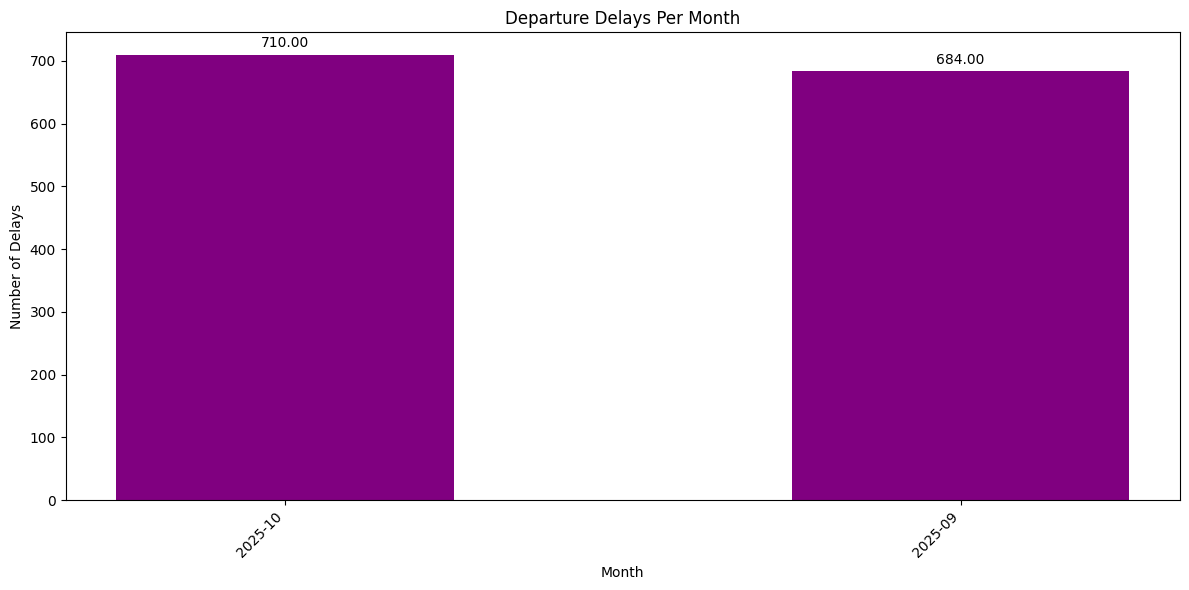

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Plotting Departure Delays Per Month.
labels = ["Month", "Number of Delays", "Departure Delays Per Month"]
plot_bar(month_delays, labels, "purple", 0.5, "month_delays.png")

In [ ]:
#Stopping Spark Session.
spark.stop()